In [16]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import CircuitQNN

In [17]:
# Generate random inputs
inputs = np.random.uniform(low=0.0, high=np.pi, size=2)
print(inputs)

[1.63031449 2.93514704]


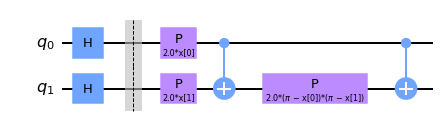

In [18]:
# Encode random vector into a circuit

%matplotlib inline

inputs = np.random.uniform(low=0.0, high=np.pi, size=2)


def encode_map(input_data, dim = 2):
    
    q_num = len(input_data)
    encode_map = ZZFeatureMap(feature_dimension=2, reps=1, insert_barriers=True)
    #encode_circuit = encode_map.bind_parameters(input_data)
    
    return encode_map


feature_map = encode_map(inputs)

feature_map.decompose().draw(output='mpl')

In [19]:
# Construct teacher and student networks

from qiskit.circuit.library import RealAmplitudes


def teacher_circuit_builder(num_qubits):
    circuit = QuantumCircuit(num_qubits)

    circuit.h(0)
    circuit.cx(0, 1)
    circuit.h(0)
    
    return circuit


def student_network_builder(num_qubits):
    circuit = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cx', entanglement='linear', rotation_blocks=['ry','rx']).decompose()
    
    return circuit

teacher_circuit = teacher_circuit_builder(2)
print(teacher_circuit)

student_network = student_network_builder(2)
print(student_network)



     ┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘     
     ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rx(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rx(θ[6]) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rx(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rx(θ[7]) ├
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘


In [20]:
# Glue together feature map and network


tc_full = feature_map.compose(teacher_circuit)

sc_full = feature_map.compose(student_network)


print(sc_full.parameters)
print(teacher_circuit.parameters)

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])])
ParameterView([])


In [21]:
# set up backed

from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)



In [22]:
#  QNN formulation


qnn_student = CircuitQNN(sc_full, feature_map.parameters, student_network.parameters, quantum_instance=q_instance)
qnn_teacher = CircuitQNN(tc_full, feature_map.parameters, teacher_circuit.parameters, quantum_instance=q_instance)




input_data = [[0., 0.],[1., 1.] ]

weights = [0. , 0., 0., 0.,0.,0.,0.,0.]

print(qnn_student.forward(input_data, weights))
print(qnn_teacher.forward(input_data, []))
print(qnn_student.num_weights)


[[0.24731445 0.2442627  0.25170898 0.25671387]
 [0.24279785 0.25610352 0.24731445 0.25378418]]
[[0.24731445 0.2442627  0.25170898 0.25671387]
 [0.3359375  0.046875   0.04370117 0.57348633]]
8


In [23]:
# Defining a PyTorch model and test it

from qiskit_machine_learning.connectors import TorchConnector
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, KLDivLoss

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn_student.num_weights) - 1)
print(initial_weights)
#initial_weights = [0. , 0., 0., 0.]
student_model = TorchConnector(qnn_student, initial_weights=initial_weights)
teacher_model = TorchConnector(qnn_teacher, initial_weights=[])


# test on a dummy input
input_data = [[0., 0.],[1., 1.]]

f_loss = MSELoss(reduction="sum")

ce_loss = CrossEntropyLoss() 

output = student_model(Tensor(input_data))  # Forward pass
target = teacher_model(Tensor(input_data))



print(output)

print(target)


print(ce_loss(output, target))


[ 0.00741414  0.03692014 -0.09518764 -0.0651257   0.08205347 -0.06788118
 -0.06402362 -0.09932174]
tensor([[0.1849, 0.2319, 0.2657, 0.3174],
        [0.3367, 0.1996, 0.1998, 0.2639]], grad_fn=<_TorchNNFunctionBackward>)
tensor([[0.2473, 0.2443, 0.2517, 0.2567],
        [0.3359, 0.0469, 0.0437, 0.5735]], grad_fn=<_TorchNNFunctionBackward>)
tensor(1.3710, grad_fn=<DivBackward1>)


In [24]:
import torch.optim as optim
# Define optimizer and loss
lr = 0.08
lr_min = 0.0005
optimizer = optim.Adam(student_model.parameters(), lr=lr)


mse_loss = MSELoss(reduction="sum")
ce_loss = CrossEntropyLoss() 
kl_div_loss = KLDivLoss()

# Start training
student_model.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.

epochs = 100

loss_list = [] 

for epoch in range(epochs):
    total_loss = []
    
    print("Learning rate:", lr )
    
    for batch_idx in range(5):
        
        input_data = np.random.uniform(low=0.0, high=np.pi, size=(1,2))
        
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        
        output = student_model(Tensor(input_data))  # Forward pass
        target = Tensor(qnn_teacher.forward(input_data, [])) # took a Qiskit QNN object defined above
        #teacher_model(Tensor(input_data))
        #print(target)
        mse_l = mse_loss(output, target)
        ce_l = ce_loss(output, target) 
        kl_div_l = kl_div_loss(output, target) 
        
        print("MSE Loss {:.4f} CE_Loss: {:.4f} KL_Loss: {:.4f}".format(mse_l, ce_l, kl_div_l))
        
        loss = 1.* mse_l + 0.01*ce_l + 0.*kl_div_l # Calculate loss
        
        #print(loss)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    
    if epoch % 10 == 0 and lr > lr_min :
        lr = lr / 2.
    
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    


Learning rate: 0.08
MSE Loss 0.0311 CE_Loss: 1.3848 KL_Loss: -0.3959
MSE Loss 0.2558 CE_Loss: 1.3963 KL_Loss: -0.2988
MSE Loss 0.3340 CE_Loss: 1.4015 KL_Loss: -0.2723
MSE Loss 0.1067 CE_Loss: 1.3237 KL_Loss: -0.3174
MSE Loss 0.0232 CE_Loss: 1.3835 KL_Loss: -0.4001
Training [1%]	Loss: 0.1639
Learning rate: 0.04
MSE Loss 0.0357 CE_Loss: 1.3542 KL_Loss: -0.3711
MSE Loss 0.6381 CE_Loss: 1.4905 KL_Loss: -0.2316
MSE Loss 0.0278 CE_Loss: 1.3829 KL_Loss: -0.4082
MSE Loss 0.4380 CE_Loss: 1.4024 KL_Loss: -0.2308
MSE Loss 0.1135 CE_Loss: 1.3089 KL_Loss: -0.3160
Training [2%]	Loss: 0.2645
Learning rate: 0.04
MSE Loss 0.1228 CE_Loss: 1.4165 KL_Loss: -0.3935
MSE Loss 0.1494 CE_Loss: 1.3475 KL_Loss: -0.2907
MSE Loss 0.0342 CE_Loss: 1.3604 KL_Loss: -0.3997
MSE Loss 0.1221 CE_Loss: 1.3437 KL_Loss: -0.3541
MSE Loss 0.1616 CE_Loss: 1.4254 KL_Loss: -0.3924
Training [3%]	Loss: 0.1318
Learning rate: 0.04
MSE Loss 0.1595 CE_Loss: 1.3297 KL_Loss: -0.3196
MSE Loss 0.1961 CE_Loss: 1.2300 KL_Loss: -0.2498
MSE Lo

MSE Loss 0.0000 CE_Loss: 1.3538 KL_Loss: -0.3999
MSE Loss 0.0000 CE_Loss: 1.3855 KL_Loss: -0.4089
MSE Loss 0.0000 CE_Loss: 1.1624 KL_Loss: -0.3386
MSE Loss 0.0000 CE_Loss: 1.3630 KL_Loss: -0.4025
Training [29%]	Loss: 0.0133
Learning rate: 0.01
MSE Loss 0.0001 CE_Loss: 1.3647 KL_Loss: -0.4025
MSE Loss 0.0000 CE_Loss: 1.3490 KL_Loss: -0.3979
MSE Loss 0.0000 CE_Loss: 1.3685 KL_Loss: -0.4042
MSE Loss 0.0000 CE_Loss: 1.3805 KL_Loss: -0.4076
MSE Loss 0.0000 CE_Loss: 1.3254 KL_Loss: -0.3957
Training [30%]	Loss: 0.0136
Learning rate: 0.01
MSE Loss 0.0000 CE_Loss: 1.3385 KL_Loss: -0.3952
MSE Loss 0.0000 CE_Loss: 1.3778 KL_Loss: -0.4065
MSE Loss 0.0000 CE_Loss: 1.0558 KL_Loss: -0.3370
MSE Loss 0.0000 CE_Loss: 1.2610 KL_Loss: -0.3784
MSE Loss 0.0000 CE_Loss: 1.3590 KL_Loss: -0.4013
Training [31%]	Loss: 0.0128
Learning rate: 0.005
MSE Loss 0.0000 CE_Loss: 0.9554 KL_Loss: -0.3116
MSE Loss 0.0000 CE_Loss: 1.1313 KL_Loss: -0.3326
MSE Loss 0.0000 CE_Loss: 1.0811 KL_Loss: -0.3461
MSE Loss 0.0000 CE_Los

MSE Loss 0.0000 CE_Loss: 1.2421 KL_Loss: -0.3749
MSE Loss 0.0000 CE_Loss: 0.7998 KL_Loss: -0.2746
MSE Loss 0.0000 CE_Loss: 0.8881 KL_Loss: -0.3003
MSE Loss 0.0000 CE_Loss: 1.3279 KL_Loss: -0.3920
Training [57%]	Loss: 0.0113
Learning rate: 0.00125
MSE Loss 0.0000 CE_Loss: 1.3204 KL_Loss: -0.3938
MSE Loss 0.0000 CE_Loss: 1.0971 KL_Loss: -0.3505
MSE Loss 0.0000 CE_Loss: 1.2548 KL_Loss: -0.3632
MSE Loss 0.0000 CE_Loss: 1.2066 KL_Loss: -0.3650
MSE Loss 0.0000 CE_Loss: 1.2863 KL_Loss: -0.3850
Training [58%]	Loss: 0.0123
Learning rate: 0.00125
MSE Loss 0.0000 CE_Loss: 1.2674 KL_Loss: -0.3793
MSE Loss 0.0000 CE_Loss: 1.0994 KL_Loss: -0.3348
MSE Loss 0.0000 CE_Loss: 1.2788 KL_Loss: -0.3755
MSE Loss 0.0000 CE_Loss: 1.3455 KL_Loss: -0.3995
MSE Loss 0.0000 CE_Loss: 1.0321 KL_Loss: -0.3401
Training [59%]	Loss: 0.0121
Learning rate: 0.00125
MSE Loss 0.0000 CE_Loss: 1.2476 KL_Loss: -0.3700
MSE Loss 0.0000 CE_Loss: 1.1480 KL_Loss: -0.3587
MSE Loss 0.0000 CE_Loss: 1.0078 KL_Loss: -0.3297
MSE Loss 0.000

Training [84%]	Loss: 0.0130
Learning rate: 0.0003125
MSE Loss 0.0000 CE_Loss: 1.2213 KL_Loss: -0.3515
MSE Loss 0.0000 CE_Loss: 1.3846 KL_Loss: -0.4086
MSE Loss 0.0000 CE_Loss: 1.3098 KL_Loss: -0.3896
MSE Loss 0.0000 CE_Loss: 1.2630 KL_Loss: -0.3695
MSE Loss 0.0000 CE_Loss: 1.3722 KL_Loss: -0.4049
Training [85%]	Loss: 0.0131
Learning rate: 0.0003125
MSE Loss 0.0000 CE_Loss: 0.8350 KL_Loss: -0.2867
MSE Loss 0.0000 CE_Loss: 1.1941 KL_Loss: -0.3586
MSE Loss 0.0000 CE_Loss: 1.3166 KL_Loss: -0.3922
MSE Loss 0.0000 CE_Loss: 1.3805 KL_Loss: -0.4075
MSE Loss 0.0000 CE_Loss: 1.3656 KL_Loss: -0.4035
Training [86%]	Loss: 0.0122
Learning rate: 0.0003125
MSE Loss 0.0000 CE_Loss: 1.2260 KL_Loss: -0.3645
MSE Loss 0.0000 CE_Loss: 1.1998 KL_Loss: -0.3340
MSE Loss 0.0000 CE_Loss: 0.9488 KL_Loss: -0.2993
MSE Loss 0.0000 CE_Loss: 0.9008 KL_Loss: -0.3094
MSE Loss 0.0000 CE_Loss: 1.2663 KL_Loss: -0.3757
Training [87%]	Loss: 0.0111
Learning rate: 0.0003125
MSE Loss 0.0000 CE_Loss: 1.3388 KL_Loss: -0.3948
MSE 

In [25]:
student_model.weight

Parameter containing:
tensor([-1.5702e+00, -1.8719e-03, -4.1066e-03,  2.7337e-02,  1.5715e+00,
        -6.8814e-04, -5.0672e-03, -2.6600e-02], requires_grad=True)

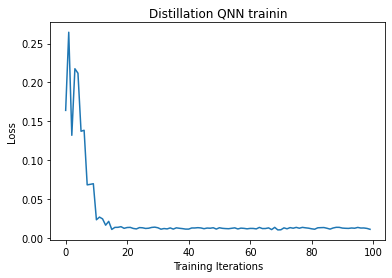

In [28]:
plt.plot(loss_list)
plt.title("Distillation QNN trainin")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()